# Synthetic spatial transcriptomics data and Sopa

In this second part, we work on synthetic cell data to get the basics of [SpatialData](https://github.com/scverse/spatialdata) and [Sopa](https://github.com/gustaveroussy/sopa).

A reminder of [SpatialData](https://spatialdata.scverse.org/en/stable/) and its various spatial elements:

<img src="https://private-user-images.githubusercontent.com/1120672/238749897-cb91071f-12a7-4b8e-9430-2b3a0f65e52f.png?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3NDM3NjY3MTAsIm5iZiI6MTc0Mzc2NjQxMCwicGF0aCI6Ii8xMTIwNjcyLzIzODc0OTg5Ny1jYjkxMDcxZi0xMmE3LTRiOGUtOTQzMC0yYjNhMGY2NWU1MmYucG5nP1gtQW16LUFsZ29yaXRobT1BV1M0LUhNQUMtU0hBMjU2JlgtQW16LUNyZWRlbnRpYWw9QUtJQVZDT0RZTFNBNTNQUUs0WkElMkYyMDI1MDQwNCUyRnVzLWVhc3QtMSUyRnMzJTJGYXdzNF9yZXF1ZXN0JlgtQW16LURhdGU9MjAyNTA0MDRUMTEzMzMwWiZYLUFtei1FeHBpcmVzPTMwMCZYLUFtei1TaWduYXR1cmU9N2Q4YjlmYzViMjBiMTdjOGQ5ZGY5ZjRiZmMyMzE1YzgzZWJhNzg5ZGNkZmE4NmYyOTYwYTNlMmU3MmI1ZDM1YSZYLUFtei1TaWduZWRIZWFkZXJzPWhvc3QifQ.WM4J3d7iVfLpSIEj4bSe2DamRgXw9brgBta3xn6E2Vg" style="max-width:1000px;width:100%"/>


In [ ]:
!pip install sopa[cellpose]

In [1]:
import sopa
import spatialdata
import matplotlib.pyplot as plt
import scanpy as sc
import spatialdata_plot

We can create a synthetic dataset via `sopa`, which will create a `SpatialData` object. We often use "`sdata`" to denote an instance of the `SpatialData` class.


In [2]:
sdata = sopa.io.toy_dataset()

[INFO] (sopa.utils.data) Image of size (4, 2048, 2048) with 400 cells and 100 transcripts per cell


This object contains two images (`image` and `he_image`), points (`misc` and `transcripts`) and shapes (`cells`).


In [3]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
└── Shapes
      └── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cells (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

For example, to access the `transcripts` element, simply use square brackets (as with dictionaries).


In [4]:
sdata["transcripts"]

,x,y,z_stack,genes,cell_id
npartitions=1,,,,,
0,float64,float64,int64,category[known],int64
39999,...,...,...,...,...


We can see that these transcripts are a `DataFrame` [Dask](https://docs.dask.org/en/stable/). This is an extension of `pandas`, which allows lazy-loading, i.e. never loading data into memory until it's needed.

> **_Question:_** What are the advantages of lazy-loading?

To "see" the data itself, you can use `.compute()`, which will return a pandas `DataFrame`:


In [5]:
sdata["transcripts"].compute()

,x,y,z_stack,genes,cell_id
0,111.111505,610.189298,1,EPCAM,1
1,109.002042,607.359920,1,EPCAM,1
2,110.386745,607.485343,-1,CXCL1,1
3,107.789506,611.847764,0,EPCAM,0
4,108.777584,611.540180,0,EPCAM,1
...,...,...,...,...,...
39995,295.752531,801.737126,-1,CD20,400
39996,295.986610,801.250840,-1,CD20,400
39997,296.716232,800.426979,0,CD20,400
39998,295.227573,803.195543,0,CD20,400


You can also use `.attrs` to access the metadata of this dataframe. For example, `attrs` contain a `transform` dictionary of transformations.

> **_Questions:_** What is the intrinsic transcript coordinate system here? The transformation to the `global` coordinate system is the composition of two transformations. Which two transformations? Write these two transformations in matrix format. Are they commutative?


In [6]:
sdata["transcripts"].attrs

{'spatialdata_attrs': {'feature_key': 'genes'},
 'transform': {'global': Affine (x, y -> x, y)
      [   10.     0. -1000.]
      [    0.    10. -6000.]
      [0. 0. 1.],
  'microns': Identity }}

We can also see that we already have cells. But, in real life, we have to segment them. That's what we'll be doing later in this tutorial.


In [7]:
sdata["cells"]

,geometry
0,"POLYGON ((120.097 86.433, 114.678 78.322, 106...."
1,"POLYGON ((207.097 54.433, 201.678 46.322, 193...."
2,"POLYGON ((317.097 20.433, 311.678 12.322, 303...."
3,"POLYGON ((417.097 53.433, 411.678 45.322, 403...."
4,"POLYGON ((433.097 25.433, 427.678 17.322, 419...."
...,...
395,"POLYGON ((1567.097 1940.433, 1561.678 1932.322..."
396,"POLYGON ((1760.097 2023.433, 1754.678 2015.322..."
397,"POLYGON ((1779.097 1935.433, 1773.678 1927.322..."
398,"POLYGON ((1962.097 1964.433, 1956.678 1956.322..."


Images can also be accessed. These are `xarray.DataArray` objects.

One of the many advantages of [`xarray`](https://docs.xarray.dev/en/stable/) is that you can name each channel. We also know the order of the dimensions (here, `y` then `x`). So you don't get lost...

> **_Question:_** What are the channels in this image? Which cell population(s) do these markers correspond to?


In [8]:
sdata["image"]

<xarray.DataArray 'image' (c: 4, y: 2048, x: 2048)> Size: 17MB
dask.array<array, shape=(4, 2048, 2048), dtype=uint8, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U4 64B 'DAPI' 'CK' 'CD3' 'CD20'
  * y        (y) float64 16kB 0.5 1.5 2.5 3.5 ... 2.046e+03 2.046e+03 2.048e+03
  * x        (x) float64 16kB 0.5 1.5 2.5 3.5 ... 2.046e+03 2.046e+03 2.048e+03
Attributes:
    transform:  {'global': Identity }

For example, with `xarray` you can easily select a channel by name, instead of having to remember that `DAPI` corresponds to index `0`. This can help avoid errors, and makes the code easier to read.


In [9]:
dapi_image = sdata["image"].sel(c="DAPI")
dapi_image

<xarray.DataArray 'image' (y: 2048, x: 2048)> Size: 4MB
dask.array<getitem, shape=(2048, 2048), dtype=uint8, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    c        <U4 16B 'DAPI'
  * y        (y) float64 16kB 0.5 1.5 2.5 3.5 ... 2.046e+03 2.046e+03 2.048e+03
  * x        (x) float64 16kB 0.5 1.5 2.5 3.5 ... 2.046e+03 2.046e+03 2.048e+03
Attributes:
    transform:  {'global': Identity }

As with transcripts, we don't have the image values, but only an "abstract view" of the image and its metadata. To get a numpy array, you can use `to_numpy`:


In [10]:
dapi_image_numpy = dapi_image.to_numpy()

This image can be segmented using Cellpose. To do this, we'll first download a pre-trained model:


In [11]:
from cellpose import models

model = models.Cellpose(model_type="cyto3")

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f

We then apply this model to our DAPI image. We specify the "expected" cell diameter in pixels.


In [13]:
mask, *_ = model.eval(dapi_image_numpy, diameter=30, channels=[0, 0])

We can take a look at the mask. At first glance, it looks like there are only zeros, but that's just because we can only see the edges of the image.


In [14]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

The `mask` can be displayed.

> **_Question:_** Why does it look like a gradient? What do each color correspond to, and why is it useful?


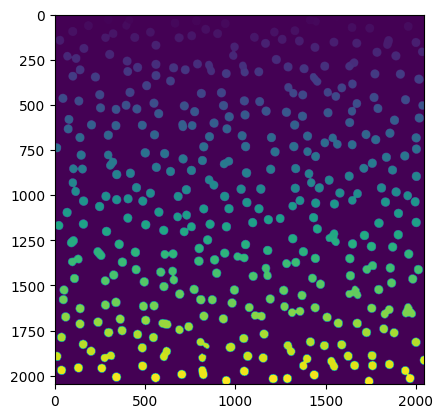

In [15]:
plt.imshow(mask)

In fact, to get things right, there are a few extra operations you can perform:

- Image pre-processing: apply operations to facilitate segmentation, such as normalization or contrast enhancement.
- Patches: when images are too large, you can't run Cellpose on the whole image, due to the RAM usage. In practice, you "slice" the image into lots of small patches, then run Cellpose on each patch.
- Resolving conflicts: patch-based segmentation can lead to artifacts at patch boundaries. These conflicts need to be resolved to ensure clean segmentation.
- Vectorization: An optimized way of manipulating segmentation is through the use of polygons. Creating polygons from an image is called vectorization.

[Sopa](https://github.com/gustaveroussy/sopa) handles all this natively, and adds a few other features (parallelization, filters, region of interest, etc.).

The image below summarizes the different stages of Sopa:

<img src="https://raw.githubusercontent.com/gustaveroussy/sopa/master/docs/assets/overview_white.png" style="max-width:1000px;width:100%"/>

For instance, to run cellpose via `sopa`:


In [16]:
# we make patches
sopa.make_image_patches(sdata, patch_width=1200)

# we run cellpose
sopa.segmentation.cellpose(sdata, channels="DAPI", diameter=30)

[INFO] (sopa.patches._patches) Added 4 patche(s) to sdata['image_patches']
[WARNING] (sopa._settings) Running without parallelization backend can be slow. Consider using a backend, e.g. via `sopa.settings.parallelization_backend = 'dask'`, or `export SOPA_PARALLELIZATION_BACKEND=dask`.
100%|██████████| 4/4 [00:39<00:00,  9.75s/it]
[INFO] (sopa.segmentation._stainings) Found 412 total cells
Resolving conflicts: 100%|██████████| 134/134 [00:00<00:00, 6604.89it/s]
[INFO] (sopa.segmentation._stainings) Added 371 cell boundaries in sdata['cellpose_boundaries']


Now we have the predictions directly as geometries. They are accessible in the `SpatialData` object, under the name `"cellpose_boundaries"`.


In [17]:
sdata["cellpose_boundaries"]

,geometry
image0,"POLYGON ((1371.512 39.366, 1375.304 52.004, 13..."
image1,"POLYGON ((1520.552 20.43, 1526.418 36.226, 153..."
image2,"POLYGON ((1819.243 6.191, 1822.418 25.226, 183..."
image3,"POLYGON ((1916 61.839, 1916.064 76.179, 1922.7..."
image4,"POLYGON ((1610.418 50.774, 1605.064 79.179, 16..."
...,...
image495,"POLYGON ((1151.515 1585.37, 1152.77 1588.298, ..."
image496,"POLYGON ((1083.918 1698.658, 1104.817 1705.936..."
image497,"POLYGON ((1122.304 1790.005, 1128.286 1798.25,..."
image498,"POLYGON ((1116.601 1922.499, 1125.591 1932.471..."


Next, we can count the transcripts in each cell, as we did in the previous tutorial. This is what `sopa.aggregate` does, with a few differences:

- Lazy-loading is used
- We also aggregate channels
- We have some filters / QCs
- Other features


In [18]:
sopa.aggregate(sdata)

[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 371 cells
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 107.59 ms


[INFO] (sopa.aggregation.channels) Aggregating channels intensity over 371 cells with mode='average'


[########################################] | 100% Completed | 105.98 ms


[INFO] (sopa.aggregation.aggregation) Filtering 0 cells
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/dev/sopa/sopa/aggregation/aggregation.py:203: ImplicitModificationWarning: Setting element `.obsm['intensities']` of view, initializing view as actual.
  self.table.obsm[SopaKeys.INTENSITIES_OBSM] = pd.DataFrame(
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:105: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


This aggregation will create a table of size `#cell` x `#genes`. We use the data structure [`AnnData`](https://anndata.readthedocs.io/en/stable/) to store this table.

> What do the variables `adata.X`, `adata.obs`, `adata.obsm` correspond to? Take a look at the documentation for the [AnnData](https://anndata.readthedocs.io/en/stable/) data structure.


In [19]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 371 × 5
    obs: 'region', 'slide', 'cell_id', 'area'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'intensities', 'spatial'

We can see that we also have information for each cell in `adata.obs`, such as the area of each cell (`area`).


In [20]:
adata.obs

,region,slide,cell_id,area
aaaaaaaa-1,cellpose_boundaries,image,aaaaaaaa-1,6854.886459
aaaaaaab-1,cellpose_boundaries,image,aaaaaaab-1,3221.701609
aaaaaaac-1,cellpose_boundaries,image,aaaaaaac-1,2822.156824
aaaaaaad-1,cellpose_boundaries,image,aaaaaaad-1,4489.170996
aaaaaaae-1,cellpose_boundaries,image,aaaaaaae-1,4522.045765
...,...,...,...,...
aaaaabgo-1,cellpose_boundaries,image,aaaaabgo-1,4720.351263
aaaaabgp-1,cellpose_boundaries,image,aaaaabgp-1,6633.124126
aaaaabha-1,cellpose_boundaries,image,aaaaabha-1,4460.130810
aaaaabhb-1,cellpose_boundaries,image,aaaaabhb-1,4634.699340


To access the counts themselves, you need to use `adata.X`, which is a `scipy` sparse matrix.

> **_Question:_** Why use a sparse matrix?


In [21]:
adata.X

<371x5 sparse matrix of type '<class 'numpy.int64'>'
	with 1835 stored elements in Compressed Sparse Row format>

To see the counts and the corresponding gene names, you can use `adata.to_df()` to convert it into `DataFrame` pandas:


In [22]:
adata.to_df()

,CD20,CD3E,CXCL1,CXCL4,EPCAM
aaaaaaaa-1,145,14,17,14,7
aaaaaaab-1,2,7,6,4,60
aaaaaaac-1,1,56,7,4,2
aaaaaaad-1,5,80,7,0,8
aaaaaaae-1,7,82,6,1,4
...,...,...,...,...,...
aaaaabgo-1,4,5,0,7,84
aaaaabgp-1,160,6,11,12,11
aaaaabha-1,77,5,8,2,7
aaaaabhb-1,81,8,3,2,5


You can also display cells in space, and color them by their transcriptomic expression.

NB: we could display polygons, but here for simplicity we display cell centroids (`spot_size` is the radius of the spot / circle used to represent each cell).


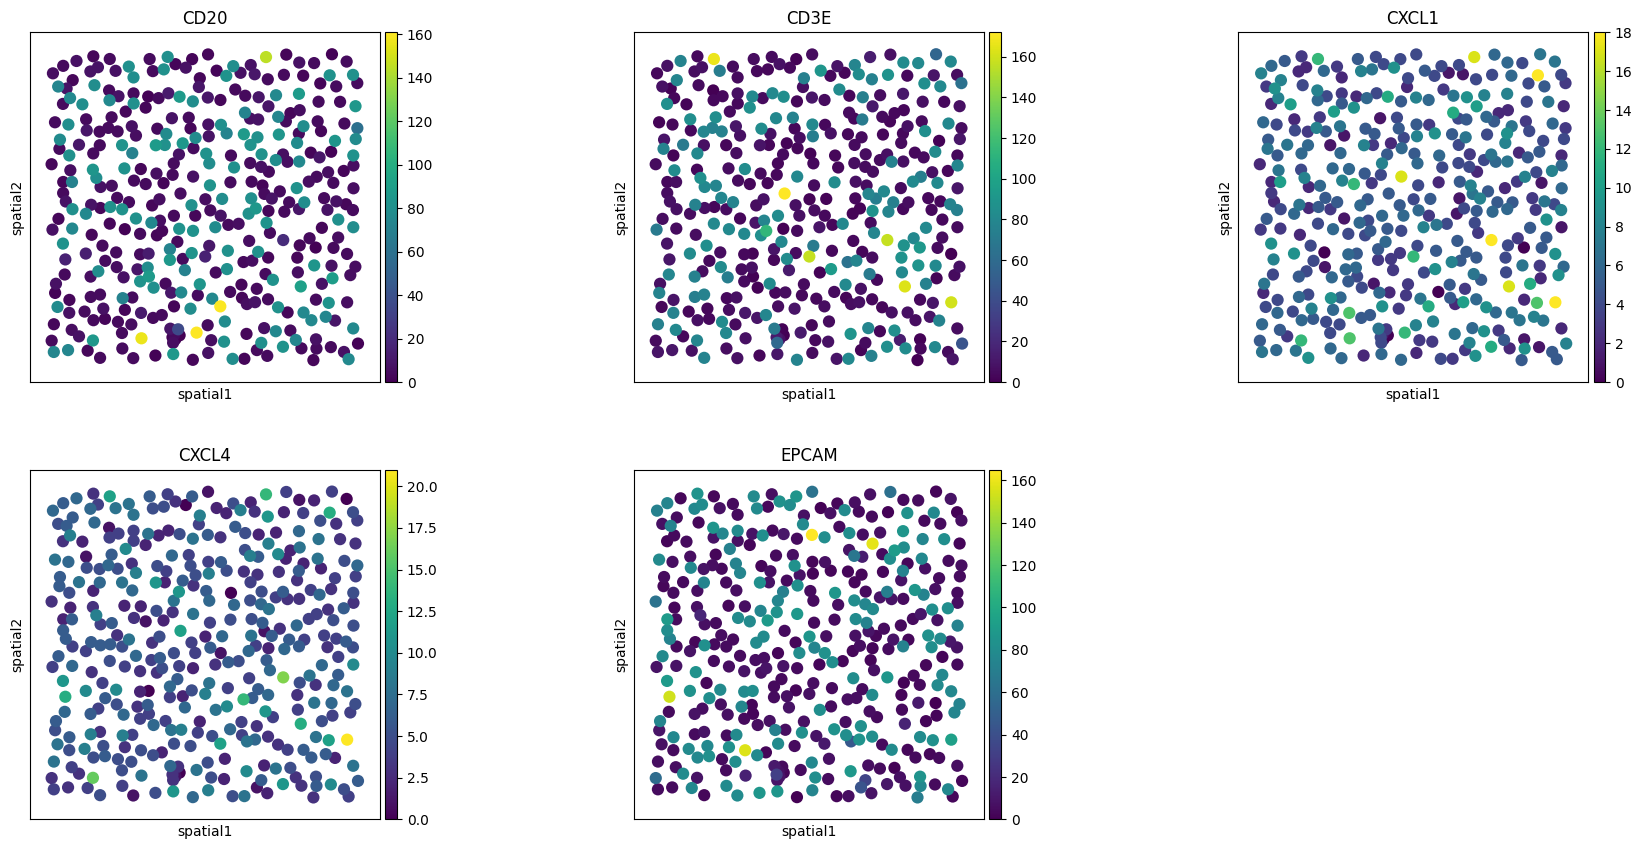

In [23]:
sc.pl.spatial(adata, color=adata.var_names, spot_size=80, ncols=3)

We can also access the average intensity of each channel in the image in each cell:


In [24]:
adata.obsm["intensities"]

,DAPI,CK,CD3,CD20
aaaaaaaa-1,125.780023,0.000000,0.000000,125.780023
aaaaaaab-1,125.556405,125.556405,0.000000,0.000000
aaaaaaac-1,123.640587,0.000000,123.640587,0.000000
aaaaaaad-1,109.068670,0.000000,109.068670,0.000000
aaaaaaae-1,108.333842,0.000000,108.333842,0.000000
...,...,...,...,...
aaaaabgo-1,103.721110,103.721110,0.000000,0.000000
aaaaabgp-1,132.775767,0.000000,0.000000,132.775767
aaaaabha-1,109.761316,0.000000,0.000000,109.761316
aaaaabhb-1,105.137661,0.000000,0.000000,105.137661


### Cell type annotation

For this tutorial, we're going to make a very simple annotation, based on the average intensity of channels in the cells. Indeed, we know that `CK` corresponds to tumor cells, `CD20` to B cells, and `CD3` to T cells.

So, for each cell, we'll calculate a score for each of these three channels, then associate a cell type according to the channel with the highest score.


In [25]:
marker_cell_dict = {"CK": "Tumoral cell", "CD20": "B cell", "CD3": "T cell"}

sopa.utils.higher_z_score(sdata.tables["table"], marker_cell_dict)

[INFO] (sopa.utils.annotation) Annotation counts: cell_type
Tumoral cell    131
T cell          121
B cell          119
Name: count, dtype: int64


The `cell_type` information has been added to `adata.obs`:


In [26]:
adata.obs

,region,slide,cell_id,area,cell_type
aaaaaaaa-1,cellpose_boundaries,image,aaaaaaaa-1,6854.886459,B cell
aaaaaaab-1,cellpose_boundaries,image,aaaaaaab-1,3221.701609,Tumoral cell
aaaaaaac-1,cellpose_boundaries,image,aaaaaaac-1,2822.156824,T cell
aaaaaaad-1,cellpose_boundaries,image,aaaaaaad-1,4489.170996,T cell
aaaaaaae-1,cellpose_boundaries,image,aaaaaaae-1,4522.045765,T cell
...,...,...,...,...,...
aaaaabgo-1,cellpose_boundaries,image,aaaaabgo-1,4720.351263,Tumoral cell
aaaaabgp-1,cellpose_boundaries,image,aaaaabgp-1,6633.124126,B cell
aaaaabha-1,cellpose_boundaries,image,aaaaabha-1,4460.130810,B cell
aaaaabhb-1,cellpose_boundaries,image,aaaaabhb-1,4634.699340,B cell


### Static (non-interactive) visualization

Using [`spatialdata_plot`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html), we can display our SpatialData object directly in the notebook. Here, we show the cell segmentation, as well as the image itself.

> **_Question:_** Look at the segmentation. Why do you think this segmentation is not correct everywhere? What would be a better approach?


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].


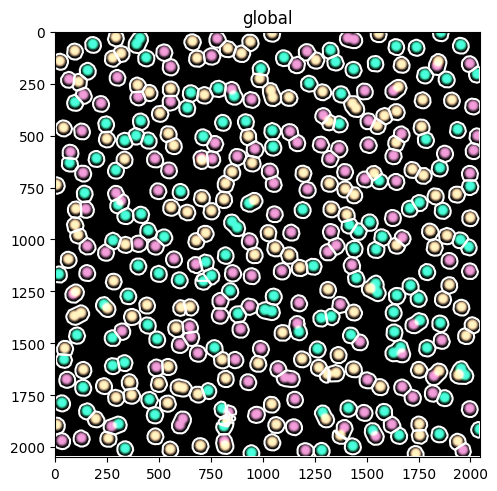

In [27]:
sdata.pl.render_images("image").pl.render_shapes(
    "cellpose_boundaries", fill_alpha=0, outline_alpha=1, outline_color="#fff"
).pl.show("global")

## Notes

- Here, Cellpose was used to segment cells from DAPI. So we didn't use transcript information. Other segmentation tools such as Baysor or Proseg could have been used for better segmentation. See the [Sopa documentation](https://gustaveroussy.github.io/sopa/api/segmentation/).
- Cell type annotation is very basic. In practice, we prefer to use tools like [Tangram](https://github.com/broadinstitute/Tangram) that map between a scRNAseq reference and the transcriptomic expressions in our spatial dataset.
- Visualization is static (i.e. non-interactive). In general, when we have large images, we prefer interactive visualizations. For this, we can use [`napari-spatialdata`](https://github.com/scverse/napari-spatialdata).
